# Training

**Goal:** To derive predictions from the dataset using the following models:
- XGBoost
- Logistic Regression
- Support Vector Machines (SVM)
- Random Forest
- K-Nearest Neighbors
- Neural Networks

The final model will be an ensemble of the best performing models.

**Load Data**

In [38]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv("../data/knight_hacks_dues_processed.csv")

# Convert class to a numeric value for use with Logistic Regression
for i, val in enumerate(data["class"]):
    if val == "Freshman":
        data.at[i, "class"] = 1
    elif val == "Sophomore":
        data.at[i, "class"] = 2
    elif val == "Junior":
        data.at[i, "class"] = 3
    elif val == "Senior":
        data.at[i, "class"] = 4
    else:
        data.at[i, "class"] = 5

data["class"] = data["class"].astype(int)

# Set features and target
drop = ["y_paid_dues", "school_grouped", "major_grouped"]

X = data.drop(columns=drop)
y = data["y_paid_dues"]

# Prefers XGBoost: 10
# Prefers Logistic Regression: 99
seed = None

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

# Inspect dimensions
print(f"Training set dimensions: {X_train.shape}")
print(f"Validation set dimensions: {X_val.shape}")
print(f"Test set dimensions: {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Training set dimensions: (471, 33)
Validation set dimensions: (157, 33)
Test set dimensions: (210, 33)


**XGBoost**

In [39]:
# Optimize hyperparameters - compare no balancing, class-weighting, and SMOTE
from imblearn.over_sampling import SMOTE

# Calculate scale_pos_weight to handle class imbalance
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()
scale_pos_weight = count_neg / count_pos
print(f"Scale Pos Weight: {scale_pos_weight:.2f}\n")

param_list = {
    'objective': ['binary:logistic'],
    'eval_metric': ['auc'],
    'max_depth': list(range(1,12)),
    "lambda": list(range(0,5)),
    "alpha": list(range(0,5)),
    'eta': list(np.linspace(0, 1, 10)),
    'min_child_weight': list(range(0,5)),
}

# Grid search with no balancing
print("Grid search with no balancing...")
model_none = xgb.XGBClassifier()
gscv_none = GridSearchCV(model_none, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_none.fit(X_train, y_train)
print(f"Best CV F1 Score (No Balancing): {gscv_none.best_score_:.4f}")

# Grid search with class-weighting
print("\nGrid search with class-weighting...")
model_cw = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
gscv_cw = GridSearchCV(model_cw, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_cw.fit(X_train, y_train)
print(f"Best CV F1 Score (Class-Weight): {gscv_cw.best_score_:.4f}")

# Grid search with SMOTE
print("\nGrid search with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model_smote = xgb.XGBClassifier()  # No scale_pos_weight needed
gscv_smote = GridSearchCV(model_smote, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_smote.fit(X_train_smote, y_train_smote)
print(f"Best CV F1 Score (SMOTE): {gscv_smote.best_score_:.4f}")

# Choose the best approach based on F1 score
scores = {
    'none': gscv_none.best_score_,
    'class_weight': gscv_cw.best_score_,
    'smote': gscv_smote.best_score_
}
best_method = max(scores, key=scores.get)
best_score = scores[best_method]

print(f"\n{'='*50}")
print(f"Best approach: {best_method.upper()} (F1: {best_score:.4f})")
print(f"{'='*50}")

if best_method == 'none':
    gscv = gscv_none
    X_train_final = X_train
    y_train_final = y_train
    best_params = gscv_none.best_params_.copy()
    scale_pos_weight_final = None
    use_smote = False
    balance_method = 'None'
elif best_method == 'class_weight':
    gscv = gscv_cw
    X_train_final = X_train
    y_train_final = y_train
    best_params = gscv_cw.best_params_.copy()
    scale_pos_weight_final = scale_pos_weight
    use_smote = False
    balance_method = 'Class-weighting'
else:  # smote
    gscv = gscv_smote
    X_train_final = X_train_smote
    y_train_final = y_train_smote
    best_params = gscv_smote.best_params_.copy()
    scale_pos_weight_final = None
    use_smote = True
    balance_method = 'SMOTE'

print("\nBest Parameters:", best_params)

Scale Pos Weight: 2.14

Grid search with no balancing...


Best CV F1 Score (No Balancing): 0.6586

Grid search with class-weighting...
Best CV F1 Score (Class-Weight): 0.6648

Grid search with SMOTE...
Best CV F1 Score (SMOTE): 0.8443

Best approach: SMOTE (F1: 0.8443)

Best Parameters: {'alpha': 0, 'eta': np.float64(0.8888888888888888), 'eval_metric': 'auc', 'lambda': 3, 'max_depth': 10, 'min_child_weight': 0, 'objective': 'binary:logistic'}


XGBoost Val Accuracy: 0.7325
XGBoost Test Accuracy: 0.7524
XGBoost Test F1: 0.5873
Balancing Method: SMOTE


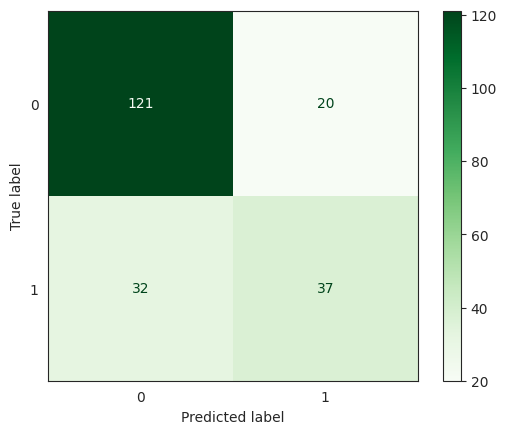

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# Train final model with best approach
if scale_pos_weight_final:
    xg_model = xgb.XGBClassifier(**best_params, scale_pos_weight=scale_pos_weight_final)
else:
    xg_model = xgb.XGBClassifier(**best_params)
xg_model.fit(X_train_final, y_train_final)

xg_pred_v = xg_model.predict(X_val)
xg_pred_ts = xg_model.predict(X_test)

xg_acc_v = accuracy_score(y_val, xg_pred_v)
xg_acc_ts = accuracy_score(y_test, xg_pred_ts)
xg_f1_ts = f1_score(y_test, xg_pred_ts)
print(f"XGBoost Val Accuracy: {xg_acc_v:.4f}")
print(f"XGBoost Test Accuracy: {xg_acc_ts:.4f}")
print(f"XGBoost Test F1: {xg_f1_ts:.4f}")
print(f"Balancing Method: {balance_method}")

cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, xg_pred_ts), display_labels=xg_model.classes_)
cf.plot(cmap=plt.cm.Greens)

**Logistic Regression**

In [41]:
param_list = {
    "C": [0.01, 0.1, 0.5, 1, 2, 5, 10],
    "penalty": ['l1', 'l2', 'elasticnet', None],
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'saga'],
    "max_iter": [3000]
}

# Grid search with no balancing
print("Grid search with no balancing...")
model_none_lr = LogisticRegression()
gscv_none_lr = GridSearchCV(model_none_lr, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_none_lr.fit(X_train, y_train)
print(f"Best CV F1 Score (No Balancing): {gscv_none_lr.best_score_:.4f}")

# Grid search with class-weighting
print("\nGrid search with class-weighting...")
model_cw_lr = LogisticRegression(class_weight='balanced')
gscv_cw_lr = GridSearchCV(model_cw_lr, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_cw_lr.fit(X_train, y_train)
print(f"Best CV F1 Score (Class-Weight): {gscv_cw_lr.best_score_:.4f}")

# Grid search with SMOTE
print("\nGrid search with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote_lr, y_train_smote_lr = smote.fit_resample(X_train, y_train)
model_smote_lr = LogisticRegression()  # No class_weight needed
gscv_smote_lr = GridSearchCV(model_smote_lr, param_list, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_smote_lr.fit(X_train_smote_lr, y_train_smote_lr)
print(f"Best CV F1 Score (SMOTE): {gscv_smote_lr.best_score_:.4f}")

# Choose the best approach based on F1 score
scores_lr = {
    'none': gscv_none_lr.best_score_,
    'class_weight': gscv_cw_lr.best_score_,
    'smote': gscv_smote_lr.best_score_
}
best_method_lr = max(scores_lr, key=scores_lr.get)
best_score_lr = scores_lr[best_method_lr]

print(f"\n{'='*50}")
print(f"Best approach: {best_method_lr.upper()} (F1: {best_score_lr:.4f})")
print(f"{'='*50}")

if best_method_lr == 'none':
    gscv_lr = gscv_none_lr
    X_train_final_lr = X_train
    y_train_final_lr = y_train
    best_params_lr = gscv_none_lr.best_params_.copy()
    class_weight_final = None
    use_smote_lr = False
    balance_method_lr = 'None'
elif best_method_lr == 'class_weight':
    gscv_lr = gscv_cw_lr
    X_train_final_lr = X_train
    y_train_final_lr = y_train
    best_params_lr = gscv_cw_lr.best_params_.copy()
    class_weight_final = 'balanced'
    use_smote_lr = False
    balance_method_lr = 'Class-weighting'
else:  # smote
    gscv_lr = gscv_smote_lr
    X_train_final_lr = X_train_smote_lr
    y_train_final_lr = y_train_smote_lr
    best_params_lr = gscv_smote_lr.best_params_.copy()
    class_weight_final = None
    use_smote_lr = True
    balance_method_lr = 'SMOTE'

print("\nBest Parameters:", best_params_lr)

Grid search with no balancing...
Best CV F1 Score (No Balancing): 0.6443

Grid search with class-weighting...
Best CV F1 Score (Class-Weight): 0.6758

Grid search with SMOTE...
Best CV F1 Score (SMOTE): 0.7859

Best approach: SMOTE (F1: 0.7859)

Best Parameters: {'C': 0.1, 'max_iter': 3000, 'penalty': 'l1', 'solver': 'liblinear'}


Logistic Regression Val Accuracy: 0.7261
Logistic Regression Test Accuracy: 0.6619
Logistic Regression Test F1: 0.5419
Balancing Method: SMOTE


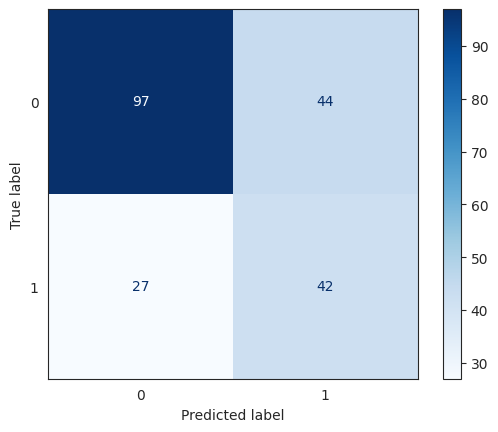

In [42]:
from sklearn.metrics import f1_score

# Train final model with best approach
if class_weight_final:
    lr_model = LogisticRegression(**best_params_lr, class_weight=class_weight_final)
else:
    lr_model = LogisticRegression(**best_params_lr)
lr_model.fit(X_train_final_lr, y_train_final_lr)

lr_pred_v = lr_model.predict(X_val)
lr_pred_ts = lr_model.predict(X_test)

lr_acc_v = accuracy_score(y_val, lr_pred_v)
lr_acc_ts = accuracy_score(y_test, lr_pred_ts)
lr_f1_ts = f1_score(y_test, lr_pred_ts)
print(f"Logistic Regression Val Accuracy: {lr_acc_v:.4f}")
print(f"Logistic Regression Test Accuracy: {lr_acc_ts:.4f}")
print(f"Logistic Regression Test F1: {lr_f1_ts:.4f}")
print(f"Balancing Method: {balance_method_lr}")

cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, lr_pred_ts), display_labels=lr_model.classes_)
cf.plot(cmap=plt.cm.Blues)

**SVM**


In [43]:
param_list_svm = {
    "C": [0.01, 0.1, 0.5, 1, 2, 5, 10],
    "kernel": ['linear', 'rbf', 'poly'],
    "gamma": ['scale', 'auto', 0.001, 0.01, 0.1],
    "degree": [2, 3, 4],  # Only used for poly kernel
    "max_iter": [1000, 3000]
}

# Grid search with no balancing
print("Grid search with no balancing...")
model_none_svm = SVC()
gscv_none_svm = GridSearchCV(model_none_svm, param_list_svm, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_none_svm.fit(X_train, y_train)
print(f"Best CV F1 Score (No Balancing): {gscv_none_svm.best_score_:.4f}")

# Grid search with class-weighting
print("\nGrid search with class-weighting...")
model_cw_svm = SVC(class_weight='balanced')
gscv_cw_svm = GridSearchCV(model_cw_svm, param_list_svm, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_cw_svm.fit(X_train, y_train)
print(f"Best CV F1 Score (Class-Weight): {gscv_cw_svm.best_score_:.4f}")

# Grid search with SMOTE
print("\nGrid search with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote_svm, y_train_smote_svm = smote.fit_resample(X_train, y_train)
model_smote_svm = SVC()  # No class_weight needed
gscv_smote_svm = GridSearchCV(model_smote_svm, param_list_svm, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_smote_svm.fit(X_train_smote_svm, y_train_smote_svm)
print(f"Best CV F1 Score (SMOTE): {gscv_smote_svm.best_score_:.4f}")

# Choose the best approach based on F1 score
scores_svm = {
    'none': gscv_none_svm.best_score_,
    'class_weight': gscv_cw_svm.best_score_,
    'smote': gscv_smote_svm.best_score_
}
best_method_svm = max(scores_svm, key=scores_svm.get)
best_score_svm = scores_svm[best_method_svm]

print(f"\n{'='*50}")
print(f"Best approach: {best_method_svm.upper()} (F1: {best_score_svm:.4f})")
print(f"{'='*50}")

if best_method_svm == 'none':
    gscv_svm = gscv_none_svm
    X_train_final_svm = X_train
    y_train_final_svm = y_train
    best_params_svm = gscv_none_svm.best_params_.copy()
    class_weight_final_svm = None
    use_smote_svm = False
    balance_method_svm = 'None'
elif best_method_svm == 'class_weight':
    gscv_svm = gscv_cw_svm
    X_train_final_svm = X_train
    y_train_final_svm = y_train
    best_params_svm = gscv_cw_svm.best_params_.copy()
    class_weight_final_svm = 'balanced'
    use_smote_svm = False
    balance_method_svm = 'Class-weighting'
else:  # smote
    gscv_svm = gscv_smote_svm
    X_train_final_svm = X_train_smote_svm
    y_train_final_svm = y_train_smote_svm
    best_params_svm = gscv_smote_svm.best_params_.copy()
    class_weight_final_svm = None
    use_smote_svm = True
    balance_method_svm = 'SMOTE'

print("\nBest Parameters:", best_params_svm)


Grid search with no balancing...
Best CV F1 Score (No Balancing): 0.6400

Grid search with class-weighting...
Best CV F1 Score (Class-Weight): 0.6831

Grid search with SMOTE...
Best CV F1 Score (SMOTE): 0.8151

Best approach: SMOTE (F1: 0.8151)

Best Parameters: {'C': 5, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': 1000}


SVM Val Accuracy: 0.7325
SVM Test Accuracy: 0.7190
SVM Test F1: 0.5755
Balancing Method: SMOTE


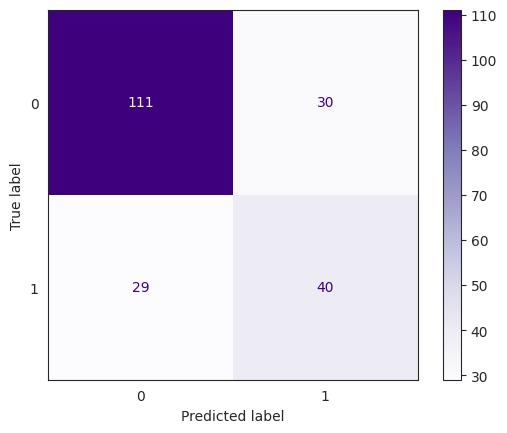

In [44]:
# Train final model with best approach
if class_weight_final_svm:
    svm_model = SVC(**best_params_svm, class_weight=class_weight_final_svm)
else:
    svm_model = SVC(**best_params_svm)
svm_model.fit(X_train_final_svm, y_train_final_svm)

svm_pred_v = svm_model.predict(X_val)
svm_pred_ts = svm_model.predict(X_test)

svm_acc_v = accuracy_score(y_val, svm_pred_v)
svm_acc_ts = accuracy_score(y_test, svm_pred_ts)
svm_f1_ts = f1_score(y_test, svm_pred_ts)
print(f"SVM Val Accuracy: {svm_acc_v:.4f}")
print(f"SVM Test Accuracy: {svm_acc_ts:.4f}")
print(f"SVM Test F1: {svm_f1_ts:.4f}")
print(f"Balancing Method: {balance_method_svm}")

cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, svm_pred_ts), display_labels=svm_model.classes_)
cf.plot(cmap=plt.cm.Purples)


**Random Forest**


In [45]:
param_list_rf = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2', None],
    "bootstrap": [True, False]
}

# Grid search with no balancing
print("Grid search with no balancing...")
model_none_rf = RandomForestClassifier(random_state=42)
gscv_none_rf = GridSearchCV(model_none_rf, param_list_rf, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_none_rf.fit(X_train, y_train)
print(f"Best CV F1 Score (No Balancing): {gscv_none_rf.best_score_:.4f}")

# Grid search with class-weighting
print("\nGrid search with class-weighting...")
model_cw_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
gscv_cw_rf = GridSearchCV(model_cw_rf, param_list_rf, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_cw_rf.fit(X_train, y_train)
print(f"Best CV F1 Score (Class-Weight): {gscv_cw_rf.best_score_:.4f}")

# Grid search with SMOTE
print("\nGrid search with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote_rf, y_train_smote_rf = smote.fit_resample(X_train, y_train)
model_smote_rf = RandomForestClassifier(random_state=42)  # No class_weight needed
gscv_smote_rf = GridSearchCV(model_smote_rf, param_list_rf, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_smote_rf.fit(X_train_smote_rf, y_train_smote_rf)
print(f"Best CV F1 Score (SMOTE): {gscv_smote_rf.best_score_:.4f}")

# Choose the best approach based on F1 score
scores_rf = {
    'none': gscv_none_rf.best_score_,
    'class_weight': gscv_cw_rf.best_score_,
    'smote': gscv_smote_rf.best_score_
}
best_method_rf = max(scores_rf, key=scores_rf.get)
best_score_rf = scores_rf[best_method_rf]

print(f"\n{'='*50}")
print(f"Best approach: {best_method_rf.upper()} (F1: {best_score_rf:.4f})")
print(f"{'='*50}")

if best_method_rf == 'none':
    gscv_rf = gscv_none_rf
    X_train_final_rf = X_train
    y_train_final_rf = y_train
    best_params_rf = gscv_none_rf.best_params_.copy()
    class_weight_final_rf = None
    use_smote_rf = False
    balance_method_rf = 'None'
elif best_method_rf == 'class_weight':
    gscv_rf = gscv_cw_rf
    X_train_final_rf = X_train
    y_train_final_rf = y_train
    best_params_rf = gscv_cw_rf.best_params_.copy()
    class_weight_final_rf = 'balanced'
    use_smote_rf = False
    balance_method_rf = 'Class-weighting'
else:  # smote
    gscv_rf = gscv_smote_rf
    X_train_final_rf = X_train_smote_rf
    y_train_final_rf = y_train_smote_rf
    best_params_rf = gscv_smote_rf.best_params_.copy()
    class_weight_final_rf = None
    use_smote_rf = True
    balance_method_rf = 'SMOTE'

print("\nBest Parameters:", best_params_rf)


Grid search with no balancing...
Best CV F1 Score (No Balancing): 0.6376

Grid search with class-weighting...
Best CV F1 Score (Class-Weight): 0.6659

Grid search with SMOTE...
Best CV F1 Score (SMOTE): 0.8583

Best approach: SMOTE (F1: 0.8583)

Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Random Forest Val Accuracy: 0.7643
Random Forest Test Accuracy: 0.7238
Random Forest Test F1: 0.5469
Balancing Method: SMOTE


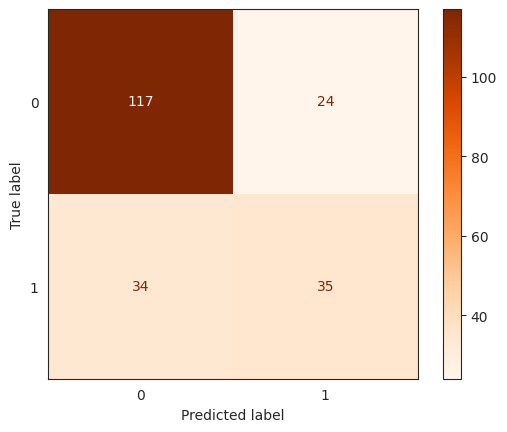

In [46]:
# Train final model with best approach
if class_weight_final_rf:
    rf_model = RandomForestClassifier(**best_params_rf, class_weight=class_weight_final_rf, random_state=42)
else:
    rf_model = RandomForestClassifier(**best_params_rf, random_state=42)
rf_model.fit(X_train_final_rf, y_train_final_rf)

rf_pred_v = rf_model.predict(X_val)
rf_pred_ts = rf_model.predict(X_test)

rf_acc_v = accuracy_score(y_val, rf_pred_v)
rf_acc_ts = accuracy_score(y_test, rf_pred_ts)
rf_f1_ts = f1_score(y_test, rf_pred_ts)
print(f"Random Forest Val Accuracy: {rf_acc_v:.4f}")
print(f"Random Forest Test Accuracy: {rf_acc_ts:.4f}")
print(f"Random Forest Test F1: {rf_f1_ts:.4f}")
print(f"Balancing Method: {balance_method_rf}")

cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, rf_pred_ts), display_labels=rf_model.classes_)
cf.plot(cmap=plt.cm.Oranges)


**K-Nearest Neighbors (KNN)**

Note: Features are already scaled using StandardScaler in the data loading cell, which is critical for distance-based algorithms like KNN.


In [47]:
param_list_knn = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "weights": ['uniform', 'distance'],
    "metric": ['euclidean', 'manhattan', 'minkowski'],
    "p": [1, 2]
}

# Grid search with no balancing
print("Grid search with no balancing...")
model_none_knn = KNeighborsClassifier()
gscv_none_knn = GridSearchCV(model_none_knn, param_list_knn, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_none_knn.fit(X_train, y_train)
print(f"Best CV F1 Score (No Balancing): {gscv_none_knn.best_score_:.4f}")

# Grid search with SMOTE
print("\nGrid search with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote_knn, y_train_smote_knn = smote.fit_resample(X_train, y_train)
model_smote_knn = KNeighborsClassifier()
gscv_smote_knn = GridSearchCV(model_smote_knn, param_list_knn, scoring='f1', n_jobs=-1, cv=3, verbose=0)
gscv_smote_knn.fit(X_train_smote_knn, y_train_smote_knn)
print(f"Best CV F1 Score (SMOTE): {gscv_smote_knn.best_score_:.4f}")

# Choose the best approach based on F1 score
scores_knn = {
    'none': gscv_none_knn.best_score_,
    'smote': gscv_smote_knn.best_score_
}
best_method_knn = max(scores_knn, key=scores_knn.get)
best_score_knn = scores_knn[best_method_knn]

print(f"\n{'='*50}")
print(f"Best approach: {best_method_knn.upper()} (F1: {best_score_knn:.4f})")
print(f"{'='*50}")

if best_method_knn == 'none':
    gscv_knn = gscv_none_knn
    X_train_final_knn = X_train
    y_train_final_knn = y_train
    best_params_knn = gscv_none_knn.best_params_.copy()
    use_smote_knn = False
    balance_method_knn = 'None'
else:  # smote
    gscv_knn = gscv_smote_knn
    X_train_final_knn = X_train_smote_knn
    y_train_final_knn = y_train_smote_knn
    best_params_knn = gscv_smote_knn.best_params_.copy()
    use_smote_knn = True
    balance_method_knn = 'SMOTE'

print("\nBest Parameters:", best_params_knn)


Grid search with no balancing...
Best CV F1 Score (No Balancing): 0.5958

Grid search with SMOTE...
Best CV F1 Score (SMOTE): 0.8640

Best approach: SMOTE (F1: 0.8640)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}


KNN Val Accuracy: 0.7452
KNN Test Accuracy: 0.7143
KNN Test F1: 0.5522
Balancing Method: SMOTE
Optimal K: 11


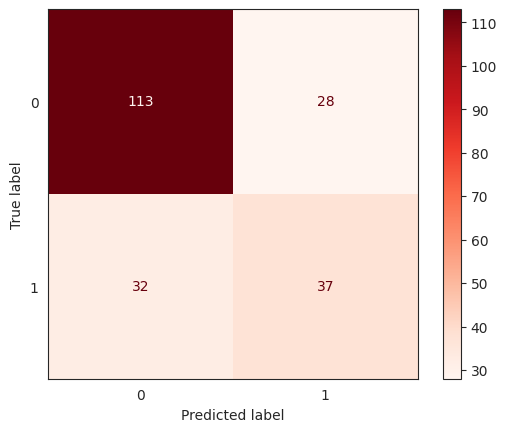

In [48]:
# Train final model with best approach
knn_model = KNeighborsClassifier(**best_params_knn)
knn_model.fit(X_train_final_knn, y_train_final_knn)

knn_pred_v = knn_model.predict(X_val)
knn_pred_ts = knn_model.predict(X_test)

knn_acc_v = accuracy_score(y_val, knn_pred_v)
knn_acc_ts = accuracy_score(y_test, knn_pred_ts)
knn_f1_ts = f1_score(y_test, knn_pred_ts)
print(f"KNN Val Accuracy: {knn_acc_v:.4f}")
print(f"KNN Test Accuracy: {knn_acc_ts:.4f}")
print(f"KNN Test F1: {knn_f1_ts:.4f}")
print(f"Balancing Method: {balance_method_knn}")
print(f"Optimal K: {best_params_knn['n_neighbors']}")

cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, knn_pred_ts), display_labels=knn_model.classes_)
cf.plot(cmap=plt.cm.Reds)


**Ensemble Model**

Combining predictions from all trained models using soft voting...

Model weights (based on val F1): XGB=0.190, LR=0.209, SVM=0.198, RF=0.205, KNN=0.197

Validation F1 Scores:
  Equal weights:     0.5882
  Weighted by F1:    0.5882

Best strategy (validation): Equal weights (F1: 0.5882)

ENSEMBLE STRATEGIES COMPARISON (Test F1 Scores)
Equal weights:        0.5909
Weighted by F1:       0.5909

Best strategy: Equal weights (F1: 0.5909)
Ensemble Test Accuracy: 0.7429
Ensemble Test F1: 0.5909


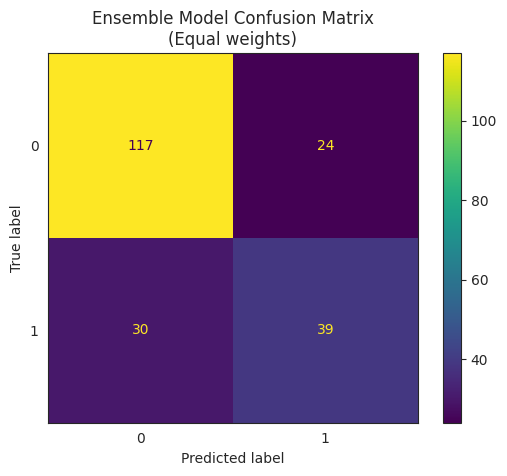


MODEL COMPARISON (Test F1 Scores)
XGBoost:              0.5873
Logistic Regression:  0.5419
SVM:                  0.5755
Random Forest:        0.5469
KNN:                  0.5522
Ensemble (Equal weights): 0.5909


In [49]:
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

print("Combining predictions from all trained models using soft voting...")

# Get probability predictions from all already-trained models (validation set)
xg_proba_val = xg_model.predict_proba(X_val)[:, 1]
lr_proba_val = lr_model.predict_proba(X_val)[:, 1]
# SVM: Check if predict_proba is available, otherwise use decision_function
try:
    svm_proba_val = svm_model.predict_proba(X_val)[:, 1]
except AttributeError:
    # Convert decision_function scores to probabilities using sigmoid
    from scipy.special import expit
    svm_scores_val = svm_model.decision_function(X_val)
    svm_proba_val = expit(svm_scores_val)  # Sigmoid transformation
rf_proba_val = rf_model.predict_proba(X_val)[:, 1]
knn_proba_val = knn_model.predict_proba(X_val)[:, 1]

# Try different ensemble strategies
# Strategy 1: Equal weights
ensemble_proba_val_equal = np.mean([xg_proba_val, lr_proba_val, svm_proba_val, 
                                     rf_proba_val, knn_proba_val], axis=0)
ensemble_pred_val_equal = (ensemble_proba_val_equal > 0.5).astype(int)
ensemble_f1_val_equal = f1_score(y_val, ensemble_pred_val_equal)

# Strategy 2: Weighted by individual model F1 scores
# Get validation F1 scores for weighting
xg_f1_val = f1_score(y_val, xg_model.predict(X_val))
lr_f1_val = f1_score(y_val, lr_model.predict(X_val))
svm_f1_val = f1_score(y_val, svm_model.predict(X_val))
rf_f1_val = f1_score(y_val, rf_model.predict(X_val))
knn_f1_val = f1_score(y_val, knn_model.predict(X_val))

weights = np.array([xg_f1_val, lr_f1_val, svm_f1_val, rf_f1_val, knn_f1_val])
weights = weights / weights.sum()  # Normalize to sum to 1
print(f"\nModel weights (based on val F1): XGB={weights[0]:.3f}, LR={weights[1]:.3f}, "
      f"SVM={weights[2]:.3f}, RF={weights[3]:.3f}, KNN={weights[4]:.3f}")

ensemble_proba_val_weighted = (xg_proba_val * weights[0] + lr_proba_val * weights[1] + 
                                svm_proba_val * weights[2] + rf_proba_val * weights[3] + 
                                knn_proba_val * weights[4])
ensemble_pred_val_weighted = (ensemble_proba_val_weighted > 0.5).astype(int)
ensemble_f1_val_weighted = f1_score(y_val, ensemble_pred_val_weighted)

# Choose best strategy for validation
strategies = {
    'Equal weights': ensemble_f1_val_equal,
    'Weighted by F1': ensemble_f1_val_weighted
}
best_strategy_val = max(strategies, key=strategies.get)
print(f"\nValidation F1 Scores:")
print(f"  Equal weights:     {ensemble_f1_val_equal:.4f}")
print(f"  Weighted by F1:    {ensemble_f1_val_weighted:.4f}")
print(f"\nBest strategy (validation): {best_strategy_val} (F1: {strategies[best_strategy_val]:.4f})")

# Test set predictions
xg_proba_test = xg_model.predict_proba(X_test)[:, 1]
lr_proba_test = lr_model.predict_proba(X_test)[:, 1]
# SVM: Check if predict_proba is available, otherwise use decision_function
try:
    svm_proba_test = svm_model.predict_proba(X_test)[:, 1]
except AttributeError:
    # Convert decision_function scores to probabilities using sigmoid
    from scipy.special import expit
    svm_scores_test = svm_model.decision_function(X_test)
    svm_proba_test = expit(svm_scores_test)  # Sigmoid transformation
rf_proba_test = rf_model.predict_proba(X_test)[:, 1]
knn_proba_test = knn_model.predict_proba(X_test)[:, 1]

# Apply same strategies to test set
# Strategy 1: Equal weights
ensemble_proba_test_equal = np.mean([xg_proba_test, lr_proba_test, svm_proba_test, 
                                      rf_proba_test, knn_proba_test], axis=0)
ensemble_pred_test_equal = (ensemble_proba_test_equal > 0.5).astype(int)
ensemble_f1_test_equal = f1_score(y_test, ensemble_pred_test_equal)

# Strategy 2: Weighted by validation F1 scores (use weights from validation)
ensemble_proba_test_weighted = (xg_proba_test * weights[0] + lr_proba_test * weights[1] + 
                                 svm_proba_test * weights[2] + rf_proba_test * weights[3] + 
                                 knn_proba_test * weights[4])
ensemble_pred_test_weighted = (ensemble_proba_test_weighted > 0.5).astype(int)
ensemble_f1_test_weighted = f1_score(y_test, ensemble_pred_test_weighted)

# Choose best strategy
strategies_test = {
    'Equal weights': ensemble_f1_test_equal,
    'Weighted by F1': ensemble_f1_test_weighted
}
best_strategy_test = max(strategies_test, key=strategies_test.get)
best_f1_test = strategies_test[best_strategy_test]

# Use best strategy for final predictions
if best_strategy_test == 'Equal weights':
    ensemble_pred_test = ensemble_pred_test_equal
    ensemble_proba_test = ensemble_proba_test_equal
else:  # Weighted by F1
    ensemble_pred_test = ensemble_pred_test_weighted
    ensemble_proba_test = ensemble_proba_test_weighted

# Test metrics
ensemble_acc_test = accuracy_score(y_test, ensemble_pred_test)
print(f"\n{'='*60}")
print("ENSEMBLE STRATEGIES COMPARISON (Test F1 Scores)")
print("="*60)
print(f"Equal weights:        {ensemble_f1_test_equal:.4f}")
print(f"Weighted by F1:       {ensemble_f1_test_weighted:.4f}")
print(f"\nBest strategy: {best_strategy_test} (F1: {best_f1_test:.4f})")
print(f"Ensemble Test Accuracy: {ensemble_acc_test:.4f}")
print(f"Ensemble Test F1: {best_f1_test:.4f}")

# Confusion matrix
cf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, ensemble_pred_test), 
                           display_labels=[0, 1])
cf.plot(cmap=plt.cm.viridis)
plt.title(f"Ensemble Model Confusion Matrix\n({best_strategy_test})")
plt.show()

# Compare individual model performances
print("\n" + "="*60)
print("MODEL COMPARISON (Test F1 Scores)")
print("="*60)
print(f"XGBoost:              {xg_f1_ts:.4f}")
print(f"Logistic Regression:  {lr_f1_ts:.4f}")
print(f"SVM:                  {svm_f1_ts:.4f}")
print(f"Random Forest:        {rf_f1_ts:.4f}")
print(f"KNN:                  {knn_f1_ts:.4f}")
print(f"{'Ensemble (' + best_strategy_test + '):':<25} {best_f1_test:.4f}")
print("="*60)


**Model Comparison Visualizations**

Comprehensive visual comparison of all models including F1 scores, accuracy, AUC, ROC curves, precision, recall, and confusion matrices.


Generating comprehensive model comparison visualizations...

Verifying confusion matrices match individual cells...
Logistic Regression F1 in comparison: 0.5419
Logistic Regression Accuracy in comparison: 0.6619
Logistic Regression confusion matrix:
[[97 44]
 [27 42]]


Model Metrics Summary:
                     Accuracy      F1  Precision  Recall     AUC
Ensemble               0.7429  0.5909     0.6190  0.5652  0.7868
XGBoost                0.7524  0.5873     0.6491  0.5362  0.7461
SVM                    0.7190  0.5755     0.5714  0.5797  0.7452
KNN                    0.7143  0.5522     0.5692  0.5362  0.7666
Random Forest          0.7238  0.5469     0.5932  0.5072  0.7679
Logistic Regression    0.6619  0.5419     0.4884  0.6087  0.7532




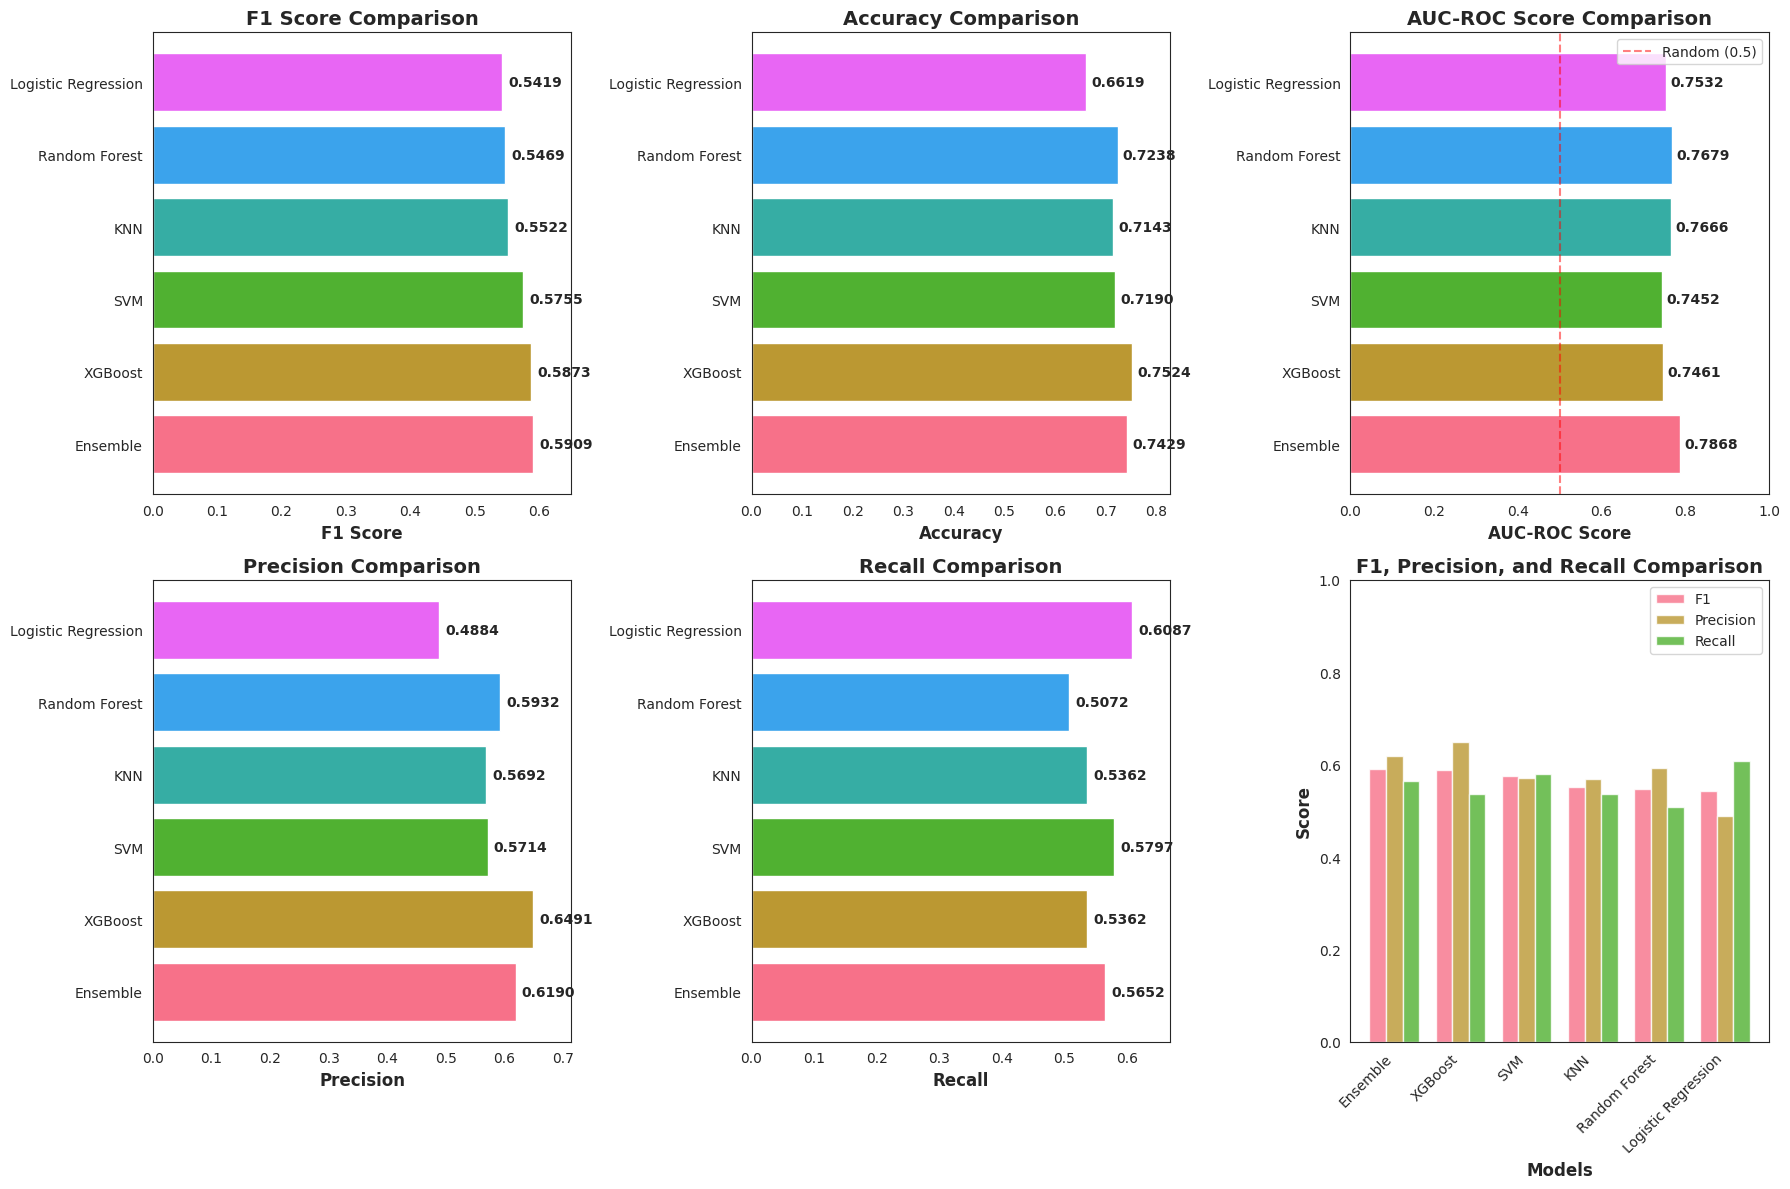

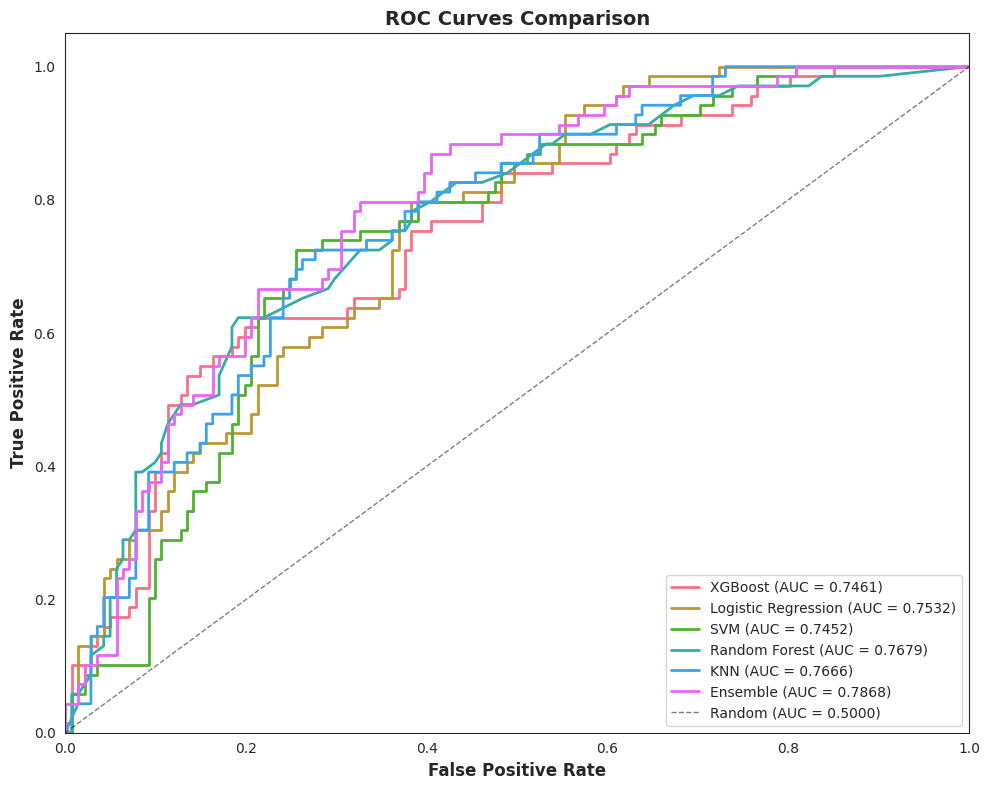

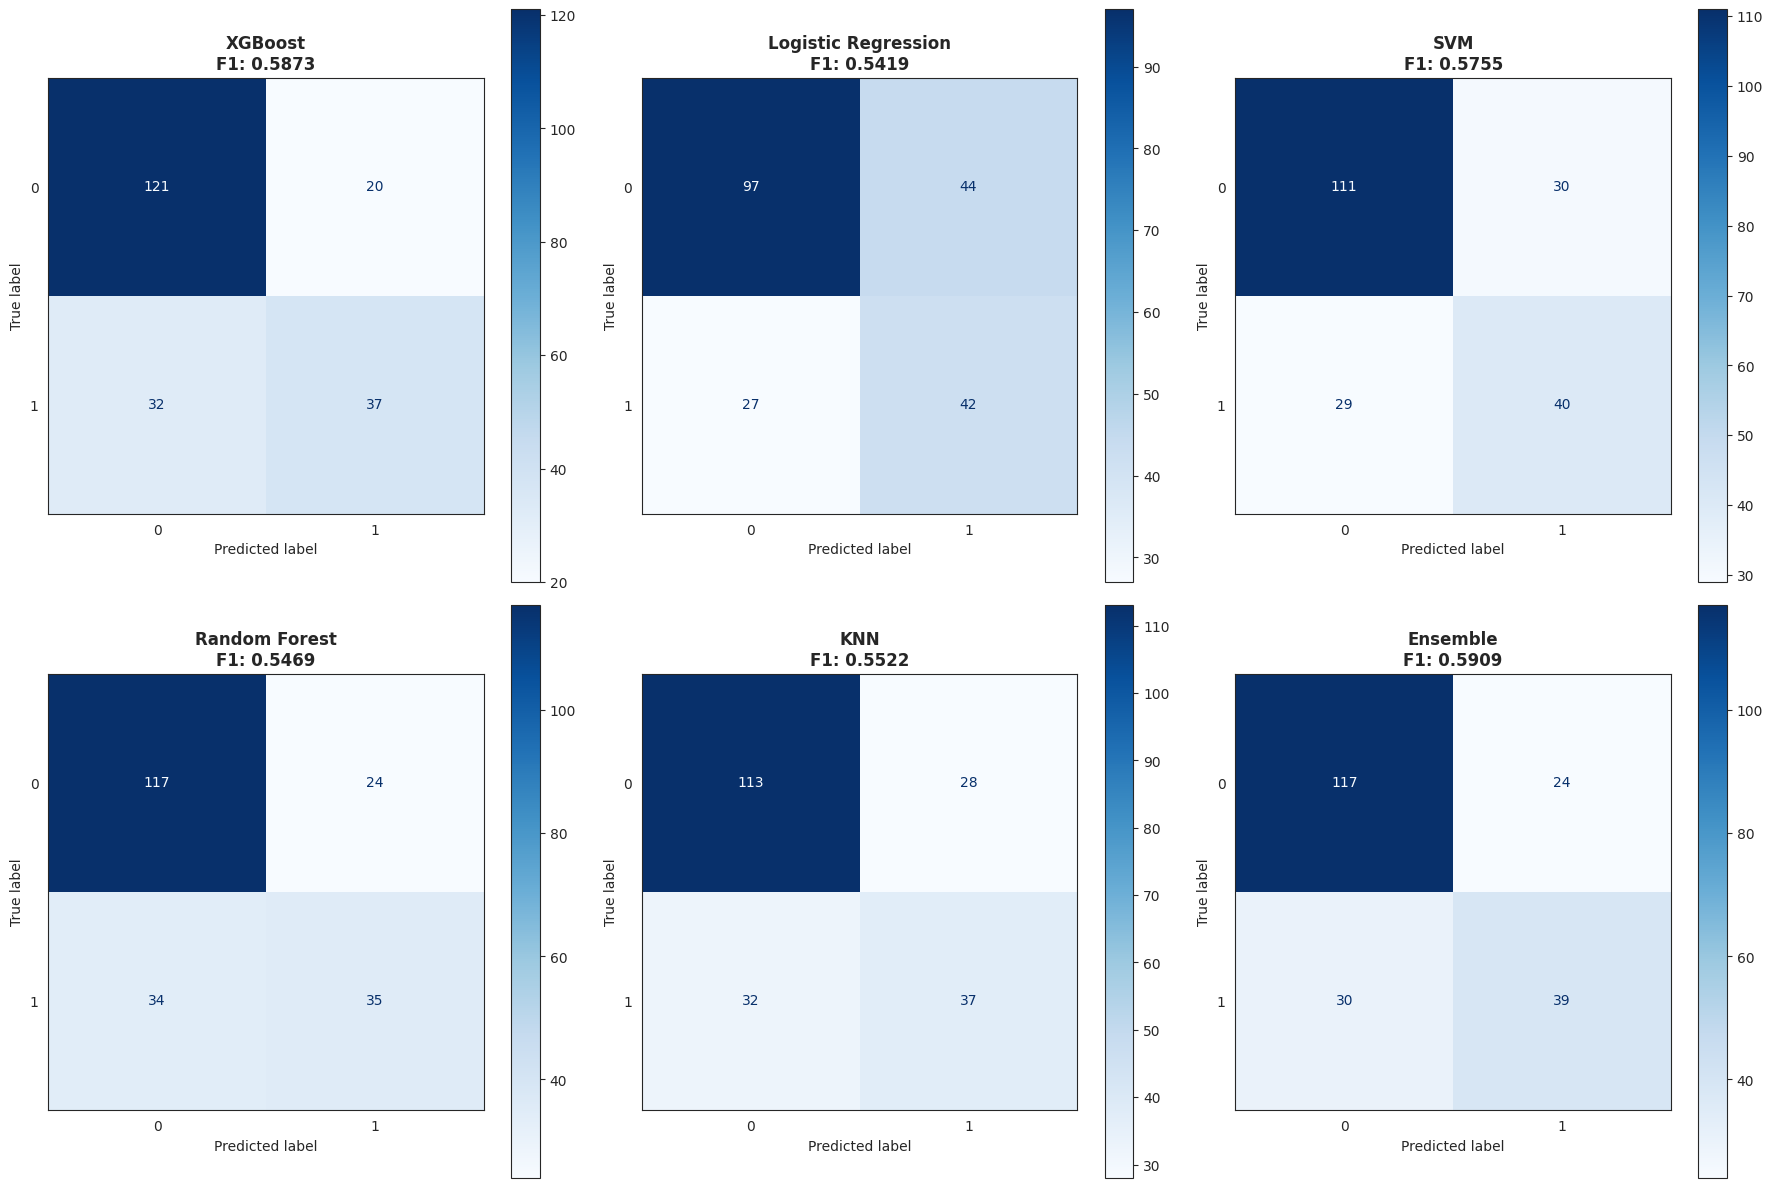


COMPREHENSIVE MODEL COMPARISON SUMMARY
                     Accuracy      F1  Precision  Recall     AUC
Ensemble               0.7429  0.5909     0.6190  0.5652  0.7868
XGBoost                0.7524  0.5873     0.6491  0.5362  0.7461
SVM                    0.7190  0.5755     0.5714  0.5797  0.7452
KNN                    0.7143  0.5522     0.5692  0.5362  0.7666
Random Forest          0.7238  0.5469     0.5932  0.5072  0.7679
Logistic Regression    0.6619  0.5419     0.4884  0.6087  0.7532

Formatted Summary:
              Model Accuracy F1 Score Precision Recall AUC-ROC
           Ensemble   0.7429   0.5909    0.6190 0.5652  0.7868
            XGBoost   0.7524   0.5873    0.6491 0.5362  0.7461
                SVM   0.7190   0.5755    0.5714 0.5797  0.7452
                KNN   0.7143   0.5522    0.5692 0.5362  0.7666
      Random Forest   0.7238   0.5469    0.5932 0.5072  0.7679
Logistic Regression   0.6619   0.5419    0.4884 0.6087  0.7532


Best Models by Metric:
  Best F1 Score:   

In [50]:
from sklearn.metrics import (roc_auc_score, roc_curve, precision_score, recall_score, 
                             classification_report, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set style - clean and minimal
plt.style.use('default')
sns.set_palette("husl")
sns.set_style("white")
plt.rcParams['axes.grid'] = False  # Disable default grid
plt.rcParams['figure.facecolor'] = 'white'

print("Generating comprehensive model comparison visualizations...\n")

# ============================================================================
# 1. Get all predictions and probabilities for comparison
# ============================================================================

# Use predictions already computed in individual model cells (ensures consistency)
# IMPORTANT: We use the EXACT same predictions that were used in individual model cells
# Get probability predictions from all models (test set)
models_predictions = {}
models_probabilities = {}
models_metrics = {}

# XGBoost - use existing predictions (exact same as in cell 5)
models_predictions['XGBoost'] = xg_pred_ts
models_probabilities['XGBoost'] = xg_model.predict_proba(X_test)[:, 1]

# Logistic Regression - use existing predictions (exact same as in cell 8)
models_predictions['Logistic Regression'] = lr_pred_ts
models_probabilities['Logistic Regression'] = lr_model.predict_proba(X_test)[:, 1]

# SVM - use existing predictions
models_predictions['SVM'] = svm_pred_ts
try:
    models_probabilities['SVM'] = svm_model.predict_proba(X_test)[:, 1]
except AttributeError:
    from scipy.special import expit
    models_probabilities['SVM'] = expit(svm_model.decision_function(X_test))

# Random Forest - use existing predictions
models_predictions['Random Forest'] = rf_pred_ts
models_probabilities['Random Forest'] = rf_model.predict_proba(X_test)[:, 1]

# KNN - use existing predictions
models_predictions['KNN'] = knn_pred_ts
models_probabilities['KNN'] = knn_model.predict_proba(X_test)[:, 1]

# Ensemble - recompute probabilities using the same individual model probabilities and strategy
# Get validation F1 scores to compute weights (same as ensemble cell)
xg_f1_val_comparison = f1_score(y_val, xg_model.predict(X_val))
lr_f1_val_comparison = f1_score(y_val, lr_model.predict(X_val))
svm_f1_val_comparison = f1_score(y_val, svm_model.predict(X_val))
rf_f1_val_comparison = f1_score(y_val, rf_model.predict(X_val))
knn_f1_val_comparison = f1_score(y_val, knn_model.predict(X_val))

weights_comparison = np.array([xg_f1_val_comparison, lr_f1_val_comparison, svm_f1_val_comparison, 
                               rf_f1_val_comparison, knn_f1_val_comparison])
weights_comparison = weights_comparison / weights_comparison.sum()

# Recompute ensemble probabilities using the same strategy as ensemble cell
if best_strategy_test == 'Equal weights':
    ensemble_proba_test_recomputed = np.mean([
        models_probabilities['XGBoost'],
        models_probabilities['Logistic Regression'],
        models_probabilities['SVM'],
        models_probabilities['Random Forest'],
        models_probabilities['KNN']
    ], axis=0)
else:  # Weighted by F1
    ensemble_proba_test_recomputed = (
        models_probabilities['XGBoost'] * weights_comparison[0] +
        models_probabilities['Logistic Regression'] * weights_comparison[1] +
        models_probabilities['SVM'] * weights_comparison[2] +
        models_probabilities['Random Forest'] * weights_comparison[3] +
        models_probabilities['KNN'] * weights_comparison[4]
    )

models_predictions['Ensemble'] = ensemble_pred_test  # Use existing predictions for consistency
models_probabilities['Ensemble'] = ensemble_proba_test_recomputed  # Recompute probabilities for AUC calculation

# Calculate metrics for all models using existing predictions
# IMPORTANT: Use the EXACT same metrics that were computed in individual model cells
models_metrics = {
    'XGBoost': {
        'Accuracy': xg_acc_ts,  # From cell 5
        'F1': xg_f1_ts,  # From cell 5
        'Precision': precision_score(y_test, xg_pred_ts),
        'Recall': recall_score(y_test, xg_pred_ts),
        'AUC': roc_auc_score(y_test, models_probabilities['XGBoost'])
    },
    'Logistic Regression': {
        'Accuracy': lr_acc_ts,  # From cell 8
        'F1': lr_f1_ts,  # From cell 8  
        'Precision': precision_score(y_test, lr_pred_ts),
        'Recall': recall_score(y_test, lr_pred_ts),
        'AUC': roc_auc_score(y_test, models_probabilities['Logistic Regression'])
    },
    'SVM': {
        'Accuracy': svm_acc_ts,
        'F1': svm_f1_ts,
        'Precision': precision_score(y_test, svm_pred_ts),
        'Recall': recall_score(y_test, svm_pred_ts),
        'AUC': roc_auc_score(y_test, models_probabilities['SVM'])
    },
    'Random Forest': {
        'Accuracy': rf_acc_ts,
        'F1': rf_f1_ts,
        'Precision': precision_score(y_test, rf_pred_ts),
        'Recall': recall_score(y_test, rf_pred_ts),
        'AUC': roc_auc_score(y_test, models_probabilities['Random Forest'])
    },
    'KNN': {
        'Accuracy': knn_acc_ts,
        'F1': knn_f1_ts,
        'Precision': precision_score(y_test, knn_pred_ts),
        'Recall': recall_score(y_test, knn_pred_ts),
        'AUC': roc_auc_score(y_test, models_probabilities['KNN'])
    },
    'Ensemble': {
        'Accuracy': ensemble_acc_test,
        'F1': best_f1_test,
        'Precision': precision_score(y_test, ensemble_pred_test),
        'Recall': recall_score(y_test, ensemble_pred_test),
        'AUC': roc_auc_score(y_test, ensemble_proba_test_recomputed)  # Use recomputed probabilities
    }
}

# Convert to DataFrame for easier plotting
metrics_df = pd.DataFrame(models_metrics).T
metrics_df = metrics_df.sort_values('F1', ascending=False)

# Verify confusion matrices match individual cells (debug output)
print("Verifying confusion matrices match individual cells...")
print(f"Logistic Regression F1 in comparison: {lr_f1_ts:.4f}")
print(f"Logistic Regression Accuracy in comparison: {lr_acc_ts:.4f}")
lr_cm_comp = confusion_matrix(y_test, lr_pred_ts)
print(f"Logistic Regression confusion matrix:\n{lr_cm_comp}")
print("\n" + "="*80 + "\n")

print("Model Metrics Summary:")
print(metrics_df.round(4))
print("\n" + "="*80 + "\n")

# ============================================================================
# 2. F1 Scores Bar Chart
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# F1 Scores
ax1 = axes[0]
bars1 = ax1.barh(metrics_df.index, metrics_df['F1'], color=sns.color_palette("husl", len(metrics_df)))
ax1.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
ax1.set_xlim(0, max(metrics_df['F1']) * 1.1)
ax1.grid(False)  # No grid
for i, (idx, row) in enumerate(metrics_df.iterrows()):
    ax1.text(row['F1'] + 0.01, i, f"{row['F1']:.4f}", va='center', fontweight='bold')

# Accuracy
ax2 = axes[1]
bars2 = ax2.barh(metrics_df.index, metrics_df['Accuracy'], color=sns.color_palette("husl", len(metrics_df)))
ax2.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_xlim(0, max(metrics_df['Accuracy']) * 1.1)
ax2.grid(False)  # No grid
for i, (idx, row) in enumerate(metrics_df.iterrows()):
    ax2.text(row['Accuracy'] + 0.01, i, f"{row['Accuracy']:.4f}", va='center', fontweight='bold')

# AUC Scores
ax3 = axes[2]
bars3 = ax3.barh(metrics_df.index, metrics_df['AUC'], color=sns.color_palette("husl", len(metrics_df)))
ax3.set_xlabel('AUC-ROC Score', fontsize=12, fontweight='bold')
ax3.set_title('AUC-ROC Score Comparison', fontsize=14, fontweight='bold')
ax3.set_xlim(0, 1)
ax3.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Random (0.5)')
ax3.grid(False)  # No grid
for i, (idx, row) in enumerate(metrics_df.iterrows()):
    ax3.text(row['AUC'] + 0.01, i, f"{row['AUC']:.4f}", va='center', fontweight='bold')
ax3.legend()

# Precision
ax4 = axes[3]
bars4 = ax4.barh(metrics_df.index, metrics_df['Precision'], color=sns.color_palette("husl", len(metrics_df)))
ax4.set_xlabel('Precision', fontsize=12, fontweight='bold')
ax4.set_title('Precision Comparison', fontsize=14, fontweight='bold')
ax4.set_xlim(0, max(metrics_df['Precision']) * 1.1)
ax4.grid(False)  # No grid
for i, (idx, row) in enumerate(metrics_df.iterrows()):
    ax4.text(row['Precision'] + 0.01, i, f"{row['Precision']:.4f}", va='center', fontweight='bold')

# Recall
ax5 = axes[4]
bars5 = ax5.barh(metrics_df.index, metrics_df['Recall'], color=sns.color_palette("husl", len(metrics_df)))
ax5.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax5.set_title('Recall Comparison', fontsize=14, fontweight='bold')
ax5.set_xlim(0, max(metrics_df['Recall']) * 1.1)
ax5.grid(False)  # No grid
for i, (idx, row) in enumerate(metrics_df.iterrows()):
    ax5.text(row['Recall'] + 0.01, i, f"{row['Recall']:.4f}", va='center', fontweight='bold')

# Combined F1, Precision, Recall
ax6 = axes[5]
x = np.arange(len(metrics_df.index))
width = 0.25
ax6.bar(x - width, metrics_df['F1'], width, label='F1', alpha=0.8)
ax6.bar(x, metrics_df['Precision'], width, label='Precision', alpha=0.8)
ax6.bar(x + width, metrics_df['Recall'], width, label='Recall', alpha=0.8)
ax6.set_xlabel('Models', fontsize=12, fontweight='bold')
ax6.set_ylabel('Score', fontsize=12, fontweight='bold')
ax6.set_title('F1, Precision, and Recall Comparison', fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_df.index, rotation=45, ha='right')
ax6.legend()
ax6.set_ylim(0, 1)
ax6.grid(False)  # No grid

plt.tight_layout()
plt.show()

# ============================================================================
# 3. ROC Curves
# ============================================================================
plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
colors = sns.color_palette("husl", len(models_probabilities))
for i, (model_name, proba) in enumerate(models_probabilities.items()):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_score = models_metrics[model_name]['AUC']
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.4f})', color=colors[i])

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5000)', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(False)  # No grid
plt.tight_layout()
plt.show()

# ============================================================================
# 4. Confusion Matrices Grid
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

model_names_list = list(models_predictions.keys())
for idx, model_name in enumerate(model_names_list):
    cm = confusion_matrix(y_test, models_predictions[model_name])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{model_name}\nF1: {models_metrics[model_name]["F1"]:.4f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(False)  # Remove grid from confusion matrices

plt.tight_layout()
plt.show()

# ============================================================================
# 5. Summary Table
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
print("="*80)
print(metrics_df.round(4).to_string())
print("="*80)

# Create a formatted summary
summary_data = []
for model_name in metrics_df.index:
    summary_data.append({
        'Model': model_name,
        'Accuracy': f"{models_metrics[model_name]['Accuracy']:.4f}",
        'F1 Score': f"{models_metrics[model_name]['F1']:.4f}",
        'Precision': f"{models_metrics[model_name]['Precision']:.4f}",
        'Recall': f"{models_metrics[model_name]['Recall']:.4f}",
        'AUC-ROC': f"{models_metrics[model_name]['AUC']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\nFormatted Summary:")
print(summary_df.to_string(index=False))
print("\n" + "="*80)

# Find best model for each metric
print("\nBest Models by Metric:")
print(f"  Best F1 Score:      {metrics_df['F1'].idxmax()} ({metrics_df['F1'].max():.4f})")
print(f"  Best Accuracy:      {metrics_df['Accuracy'].idxmax()} ({metrics_df['Accuracy'].max():.4f})")
print(f"  Best AUC-ROC:       {metrics_df['AUC'].idxmax()} ({metrics_df['AUC'].max():.4f})")
print(f"  Best Precision:     {metrics_df['Precision'].idxmax()} ({metrics_df['Precision'].max():.4f})")
print(f"  Best Recall:        {metrics_df['Recall'].idxmax()} ({metrics_df['Recall'].max():.4f})")
print("="*80)
